In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Update path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clustering/src')

!pip install pymysql
!pip install -U scikit-learn

from prepare import wrangle_zillow, calc_vif, plot_corr

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

lucario = ['#6EA4BB', '#C04C4B', '#464646', '#E7E7E6', '#F0DBA5']
puff = ['#008393', '#E3ABB5', '#040405', '#F5D9E2']
sns.set_palette(sns.color_palette(lucario))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression


# Failing to Predict Errors in Zillow's Zestimate

## by Steven Newton
### Using clustering and linear models to predict the errors in Zillow Zestimates proves to be an exercise in futility.

## TL;DR

This project is easy to summarize on account of the fact that the modeling produces **no new insights.** We wanted to know what was driving the error terms in the 2017 Zillow Zestimates of single-unit properties and after this project we still would like to know. The Zestimates are already incredibly accurate. In my professional opinion, it's not worth the effort to work to improve the model, at least with the available data. Instead, go use it. Now let's walk through the Sisyphean task of predicting Zestimate log error.



## Outline

* Preprocessing
  * Incomplete data
  * Outliers
  * Distribution of target
  * Correlation and multicollinearity

* Modeling
  * Constant model
  * Clusters
  * Feature selection
  * Linear models

* Evaluation on test data

* Recommendations

# Preprocessing 

Caveat: We are only looking at single-unit properties.

Any column missing over 40 percent of data was excluded off the bat. I filled in *building quality* and *acres* with the median values. I dropped any row missing any other columns, which included 353 incomplete cases. Categorical variables one-hot encoded for this analysis include *zip code* and *heating system*. Also included as binary, categorical variables are *poolcnt* and *tax delinquecy flag*.

Outliers were tricky as there were some really bad errors (a billion dollar house?) that were doubling the mean error. At first, I looked at these outliers by themselves, thinking I could predict those and improve the model that way. In fact, the extreme erros looked like the rest of the data. I dropped 1436 outliers at the 1st and 99th percentiles, thereby shortening the tails of the target variable.

In [ ]:
X_train, X_test, X_val, y_orig, y_test, y_val = wrangle_zillow(test_size=.15, clip=False)

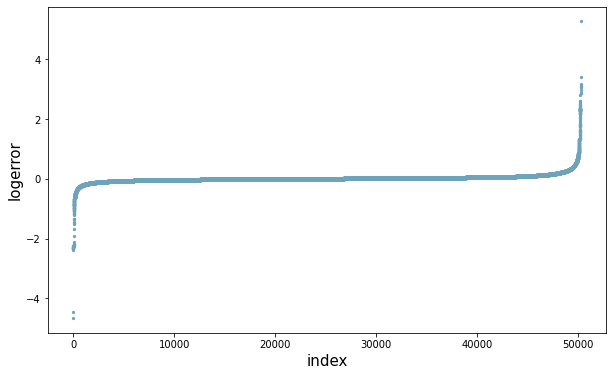

In [4]:
plt.figure(figsize=(10,6))
plt.scatter(range(y_orig.shape[0]), np.sort(y_orig), s=5)
plt.xlabel('index', fontsize=15)
plt.ylabel('logerror', fontsize=15)
plt.show()

In [3]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(test_size=.15, clip=True)


Missing values in ['delinquet', 'poolcnt', 'heating', 'regionidcity'] replaced with zeros

Missing values in ['buildquality', 'lotsqft'] replaced with median

These columns were dropped.
Empty DataFrame
Columns: [missing count, missing %]
Index: []

353 incomplete cases dropped from the data.
1436 outliers clipped at 1st and 99th percentiles based on ['logerror'].

X_train (49233, 115), X_test (10550, 115), X_val (10550, 115)
y_train (49233,), y_test (10550,), y_val (10550,)


Below is the final distribution of the log errors in the training data: normal.

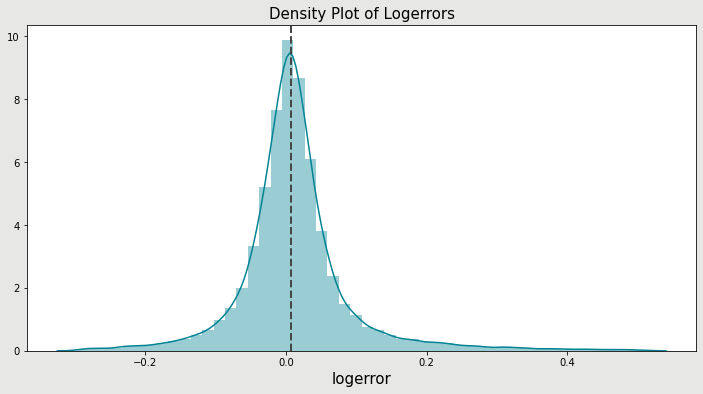

In [5]:
f=plt.figure(figsize=(12, 6))
sns.distplot(y_train, bins=50, kde=True, color=puff[0])
f.set_facecolor(lucario[3])
plt.axvline(y_train.median(), color=lucario[2],
            linestyle='dashed', linewidth=2)
plt.ylabel("")
plt.xlabel("logerror", fontsize=15)
plt.title("Density Plot of Logerrors", fontsize=15)
plt.show()

**Root Mean Squared Logarithmic Error (RMSLE)** is used when **predictions have large deviations.** Home values range from a few thousand dollars to several millions and we don't want to punish prediction deviations as much as with MSE.

RMSLE = $\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:

  $n$ is the total number of observations in the (public/private) data set,

  $p_i$ is your prediction of target, and

  $a_i$ is the actual target for $i$.

  $log(x)$ is the natural logarithm of $x$ ($log_e(x)$.

I calculated the implied Zestimates using log errors and tax values. Half of all predictions are withing \$10,000 of the actual price. Considering that the average home in the data set sells for \$480,000, this is incredibly accurate. Further research of the 2017 Zillow Prize revealed that these Zestimates were made with an ensemble of over seven million models. My expectations for finding patterns in the errors, which would suggest a possible improvement, are low.

In [63]:
#logerror = log(pred) - log(real)
zestimate = np.exp(y_train + np.log(X_train.taxvalue))
actual = X_train.taxvalue
rmse = zestimate - actual
X_train.taxvalue.mean()

482714.89953892713

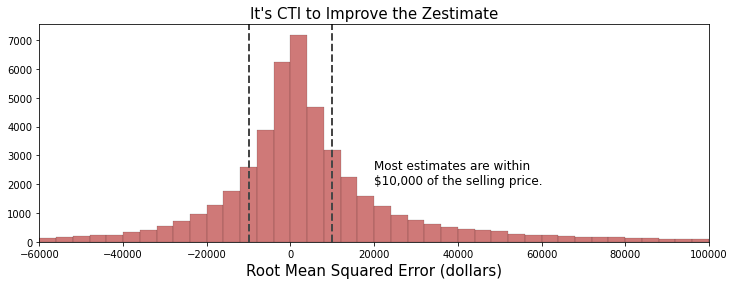

In [21]:
f=plt.figure(figsize=(12, 4))
sns.histplot(rmse.clip(-1e6,1e6), color=lucario[1], bins=500)
plt.xlim(-60000, 100000)
plt.ylabel("")
plt.xlabel("Root Mean Squared Error (dollars)", fontsize=15)
plt.title("It's CTI to Improve the Zestimate", fontsize=15)
plt.axvline(-10000, color=lucario[2], linestyle='dashed', linewidth=2)
plt.axvline(10000, color=lucario[2], linestyle='dashed', linewidth=2)
plt.text(20000, 2000, f'Most estimates are within\n$10,000 of the selling price.', fontsize=12)
plt.show()

We find that the features' correlations with the target are low (all under .07) We see some of the engineered features among the better ones: value by square foot and living area to lot size ratio. 

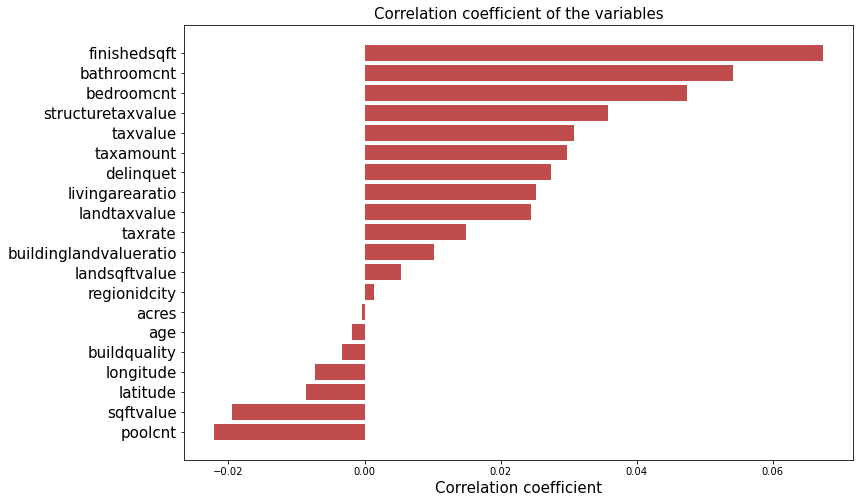

In [6]:
x_cols = [col for col in X_train.columns if X_train[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
  labels.append(col)
  values.append(np.corrcoef(X_train[col].values, y_train)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color=lucario[1])
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal', fontsize=15)
ax.set_xlabel("Correlation coefficient", fontsize=15)
ax.set_title("Correlation coefficient of the variables", fontsize=15)
plt.show()

Let's sort the better correlated features from high to low.

In [7]:
corr_df_sel = corr_df[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel.sort_values(by="corr_values", ascending=False)

,col_labels,corr_values
5,finishedsqft,0.067337
0,bathroomcnt,0.054181
1,bedroomcnt,0.047414
8,structuretaxvalue,0.035763
10,taxvalue,0.030803
12,taxamount,0.029753
9,delinquet,0.027325
13,livingarearatio,0.025255
11,landtaxvalue,0.024414
18,sqftvalue,-0.019459


Unfortunately, the highest correlated features are multicollinear. What small power the features do have to predict the target is identical to other features and not adding new predictive power. In order to make a simpler, more stable model, it is advisable to drop the multicollinear features.

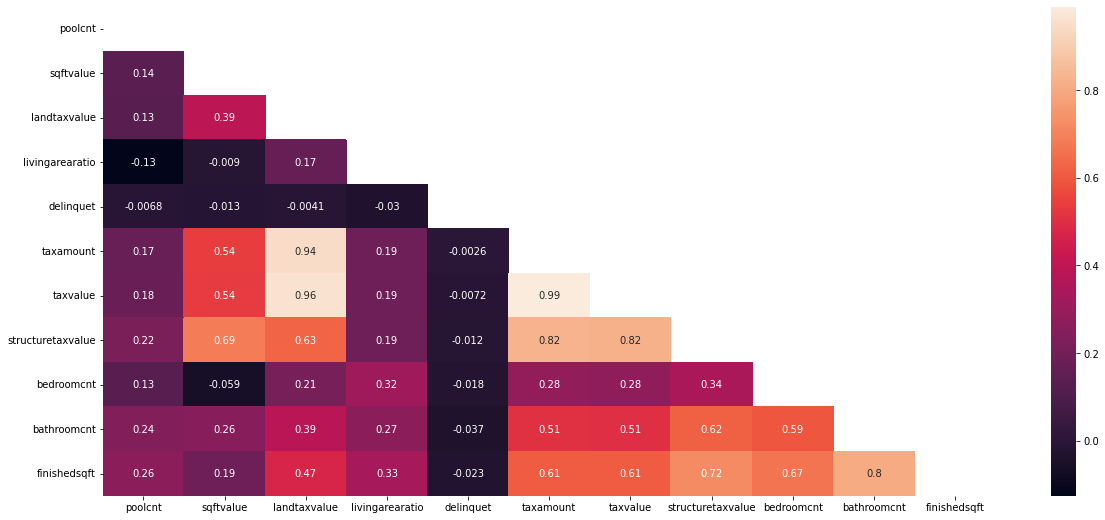

In [16]:
cols_to_use = corr_df_sel.col_labels.tolist()
plot_corr(X_train[cols_to_use]);

In [17]:
cols_to_drop = ['landtaxvalue', 'taxamount', 'bathroomcnt', 'structuretaxvalue', 'bedroomcnt']

In [18]:
cols_to_use  = [x for x in cols_to_use if x not in cols_to_drop]

In [19]:
calc_vif(X_train[cols_to_use])

,variables,VIF
0,poolcnt,1.5
1,sqftvalue,3.2
2,livingarearatio,2.9
3,delinquet,1.0
4,taxvalue,2.9
5,finishedsqft,5.8


# Modeling

Making a constant prediction is a good way to get a sense of what it means to have good performance on model. In this case, the complex model will perform as well as the baseline, constant model.

## Mean Model

In [22]:
#constant baseline
best_const = np.round(np.expm1(y_train.mean()),2)

#rmse/mape of logerror mean
y_pred = np.zeros(len(y_train))+best_const
mape_train = mean_absolute_percentage_error(y_train, y_pred)
rmse_train = mean_squared_error(y_train, y_pred, squared=False)

y_pred = np.zeros(len(y_val))+best_const
mape_val = mean_absolute_percentage_error(y_val, y_pred)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)
r2_baseline = r2_score(y_val, y_pred)

print(f"RMSE/MAPE using Mean of {best_const}:\n  Train/In-Sample: {round(rmse_train, 4), round(mape_train, 1)*100}", 
      f"\n  Validate/Out-of-Sample: {round(rmse_val, 4), round(mape_val, 1)*100}")

RMSE/MAPE using Mean 0.01:
  Train/In-Sample: (0.0819, 260.0) 
  Validate/Out-of-Sample: (0.0835, 260.0)


## Clusters

These clusters are an attempt to find new relationships. None are important.


Missing values in ['delinquet', 'poolcnt', 'heating', 'regionidcity'] replaced with zeros

Missing values in ['buildquality', 'lotsqft'] replaced with median

These columns were dropped.
Empty DataFrame
Columns: [missing count, missing %]
Index: []

353 incomplete cases dropped from the data.
1436 outliers clipped at 1st and 99th percentiles based on ['logerror'].

X_train (49233, 115), X_test (10550, 115), X_val (10550, 115)
y_train (49233,), y_test (10550,), y_val (10550,)


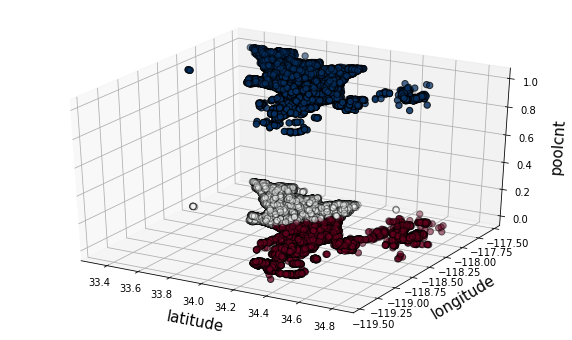

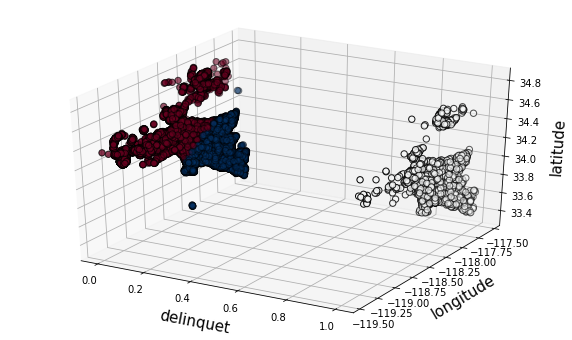

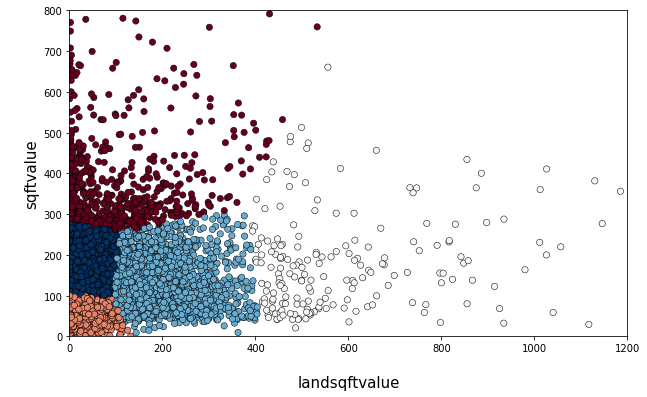

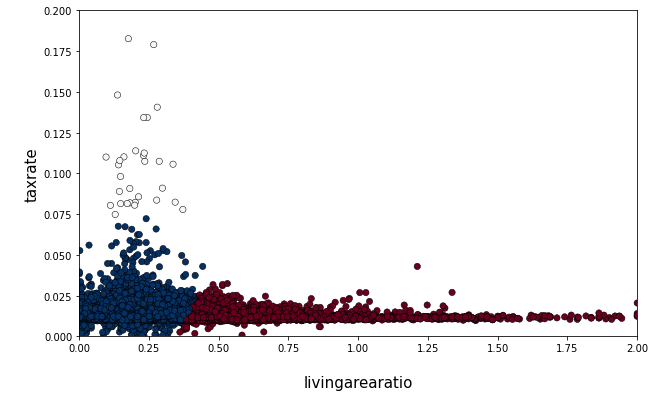

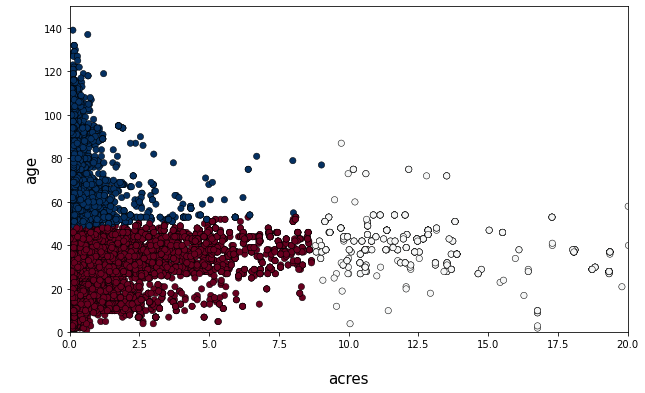

In [61]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(test_size=.15, clip=True)

clusters = [
            [[3],["latitude", "longitude", "poolcnt"]],
            [[3],["delinquet", "longitude", "latitude"]],
            [[5, 1200, 800],["landsqftvalue", "sqftvalue"]],
            [[3, 2, .2],["livingarearatio", "taxrate"]],
            [[3, 20, 150],["acres", "age"]]
            ]

for idx, X in enumerate(clusters):

  k = X[0][0]

  kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=k))
  dbscan = make_pipeline(StandardScaler(), DBSCAN())

  X_train[f'CLUSTER{idx}'] = kmeans.fit_predict(X_train[X[1]])
  X_val[f'CLUSTER{idx}'] = kmeans.fit_predict(X_val[X[1]])
  X_test[f'CLUSTER{idx}'] = kmeans.fit_predict(X_test[X[1]])

  f = plt.figure(figsize=(10, 6))

  if len(X[1]) == 3:
    ax = f.add_subplot(111, projection='3d')
    x = np.array(X_train[X[1][0]])
    y = np.array(X_train[X[1][1]])
    z = np.array(X_train[X[1][2]])
    ax.scatter(x,y,z, marker='o', edgecolor='k',
               c=X_train[f'CLUSTER{idx}'], s=40, cmap='RdBu')

    ax.set_xlabel('\n'+X[1][0], fontsize=15)
    ax.set_ylabel('\n'+X[1][1], fontsize=15)
    ax.set_zlabel('\n'+X[1][2], fontsize=15)

  if len(X[1]) == 2:
    x = np.array(X_train[X[1][0]])
    y = np.array(X_train[X[1][1]])
    plt.ylim(0,X[0][2])
    plt.xlim(0,X[0][1])
    sns.scatterplot(x,y, marker='o', edgecolor='k',
                    c=X_train[f'CLUSTER{idx}'], s=40, cmap='RdBu')

    plt.xlabel('\n'+X[1][0], fontsize=15)
    plt.ylabel('\n'+X[1][1], fontsize=15)

  plt.show()

  X_train = pd.concat([X_train,
                       pd.get_dummies(X_train[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  X_val = pd.concat([X_val,
                     pd.get_dummies(X_val[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  X_test = pd.concat([X_test,
                      pd.get_dummies(X_test[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  
  X_train.drop(f'CLUSTER{idx}', axis=1, inplace=True)
  X_val.drop(f'CLUSTER{idx}', axis=1, inplace=True)
  X_test.drop(f'CLUSTER{idx}', axis=1, inplace=True)

  

Here are 127 features in X, including 89 zip codes shown to have a significant linear relationship to the target as well as 17 cluster variables created with one-hot encoding in the above cell.

In [67]:
X_train.head(2)

,bathroomcnt,bedroomcnt,poolcnt,buildquality,regionidcity,finishedsqft,latitude,longitude,structuretaxvalue,delinquet,taxvalue,landtaxvalue,taxamount,livingarearatio,buildinglandvalueratio,taxrate,age,age_bins,acres,sqftvalue,landsqftvalue,Los Angeles,Orange,Ventura,Central,Floor,Forced air,Solar,95989.0,95997.0,96007.0,96013.0,96020.0,96023.0,96026.0,96027.0,96038.0,96043.0,96044.0,96046.0,...,96939.0,96941.0,96946.0,96947.0,96948.0,96951.0,96954.0,96959.0,96961.0,96962.0,96969.0,96974.0,96975.0,96981.0,96985.0,97007.0,97018.0,97023.0,97026.0,97048.0,97068.0,97106.0,97111.0,97113.0,97298.0,97318.0,97329.0,97330.0,latitude_longitude_1,latitude_longitude_2,delinquet_longitude_1,delinquet_longitude_2,landsqftvalue_sqftvalue_1,landsqftvalue_sqftvalue_2,landsqftvalue_sqftvalue_3,landsqftvalue_sqftvalue_4,livingarearatio_taxrate_1,livingarearatio_taxrate_2,acres_age_1,acres_age_2
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12851549,3.0,4.0,1.0,7.0,22827.0,2325.0,33.981098,-117.871244,115752.0,0.0,142236.0,26484.0,2094.55,0.039135,4.370639,0.014726,53.0,1,1.363866,49.785806,0.445784,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1
17239766,2.0,3.0,1.0,6.0,27110.0,1686.0,34.295531,-118.697774,179245.0,0.0,298736.0,119491.0,3588.80,0.173814,1.500071,0.012013,53.0,1,0.222681,106.313760,12.318660,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1


## Feature Selection

Using more or fewer features based on best feature selection does not change the predictions of log error, which hover just above zero for all choices k features. In this example, ten features are whittled down to five after dropping multicollienar features.

In [64]:
select = SelectKBest(f_regression, k=15)
select.fit_transform(X_train, y_train)
filter = select.get_support()
top_features = pd.Series(X_train.columns[filter])

final_features = []
for x in top_features:
  if x not in cols_to_drop:
    final_features.append(x)
pd.DataFrame(final_features, columns=["X"])

,X
0,finishedsqft
1,delinquet
2,taxvalue
3,livingarearatio
4,96280
5,96951
6,97113
7,delinquet_longitude_1
8,landsqftvalue_sqftvalue_1
9,landsqftvalue_sqftvalue_4


Lasso Lars and Tweedie produce prediction comparable to the mean model, while regular OLS regression and polynomial regression tends to hav overfitting issues. This example uses Tweedie.

In [65]:
X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = X_test[final_features]

lm1 = make_pipeline(StandardScaler(), LinearRegression())
lm2 = make_pipeline(StandardScaler(), LassoLars())
lm3 = make_pipeline(StandardScaler(), TweedieRegressor())
lm4 = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())

#change this line to try different models
model = lm3

model.fit(X_train_final, y_train)
y_pred_train = model.predict(X_train_final)
y_pred_val = model.predict(X_val_final)

#rmse/mape of linear model
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
r2_baseline = r2_score(y_val, y_pred_val)

print(f"RMSE/MAPE using Linear Model:\n  Train/In-Sample: {round(rmse_train, 4), round(mape_train, 1)*100}", 
      f"\n  Validate/Out-of-Sample: {round(rmse_val, 4), round(mape_val, 1)*100}")

RMSE/MAPE using Linear Model:
  Train/In-Sample: (0.0815, 310.0) 
  Validate/Out-of-Sample: (0.0833, 370.0)


## Evaluation: A Trivial Difference

Despite its complexity, the best linear model isn't significantly outperforming the default model of predicting the mean error for every observation. Across all models, the residuals don't indicate that the model is picking up on any signal within the error terms; variation is meaningless noise.

In [66]:
y_pred_test = model.predict(X_test_final)

mape_lm = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_lm = mean_squared_error(y_test, y_pred_test, squared=False)

mape_mean = mean_absolute_percentage_error(y_test, np.zeros(len(y_test))+best_const)
rmse_mean = mean_squared_error(y_test, np.zeros(len(y_test))+best_const, squared=False)

print(f"RMSE/MAPE using Linear Model on test: {round(rmse_lm, 4), round(mape_lm, 1)*100}", 
      f"\nRMSE/MAPE using Mean Model on test: {round(rmse_mean, 4), round(mape_mean, 1)*100}")

RMSE/MAPE using Linear Model on test: (0.0826, 310.0) 
RMSE/MAPE using Mean Model on test: (0.0827, 220.00000000000003)


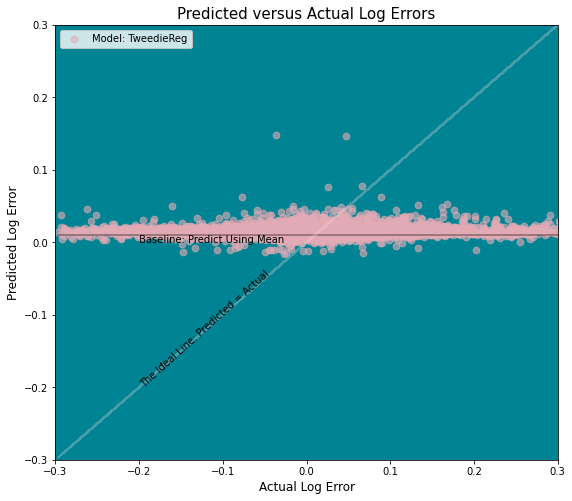

In [46]:
f, ax = plt.subplots(figsize=(9,8))
ax.set_facecolor(puff[0])

alpha_line, alpha_scatter, scatter_size = .3, .6, 45
rotation = 42
limit = -.3
scatter_color = puff[1]

plt.plot(y_test, np.zeros(len(y_test))+best_const, alpha=alpha_line,
         color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (-.2, 0))
plt.plot(y_test, y_test, alpha=alpha_line, color=puff[3], label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (-.2, -.2), rotation=rotation)
plt.scatter(y_test, model.predict(X_test_final), alpha=alpha_scatter,
            color=scatter_color, s=scatter_size, label="Model: TweedieReg")
plt.legend()
plt.xlabel("Actual Log Error", fontsize=12)
plt.ylabel("Predicted Log Error", fontsize=12)
plt.xlim(limit, abs(limit))
plt.ylim(limit, abs(limit))
plt.title("Predicted versus Actual Log Errors", fontsize=15)
#plt.savefig("img/preds.png")
plt.show()

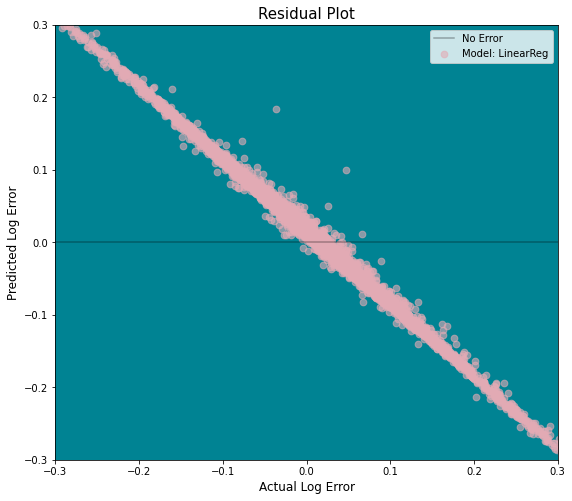

In [47]:
f, ax = plt.subplots(figsize=(9,8))
ax.set_facecolor(puff[0])

plt.axhline(label="No Error", color="black", alpha=alpha_line)
plt.scatter(y_test, model.predict(X_test_final) - y_test, alpha=alpha_scatter,
            color=scatter_color, s=scatter_size, label="Model: LinearReg")
plt.legend()
plt.xlabel("Actual Log Error", fontsize=12)
plt.ylabel("Predicted Log Error", fontsize=12)
plt.xlim(limit, abs(limit))
plt.ylim(limit, abs(limit))
plt.title("Residual Plot", fontsize=15)
#plt.savefig("img/resid.png")
plt.show()

The model is failing to mimic the distribution of actual log errors. Instead predicting almost every value very near to zero.

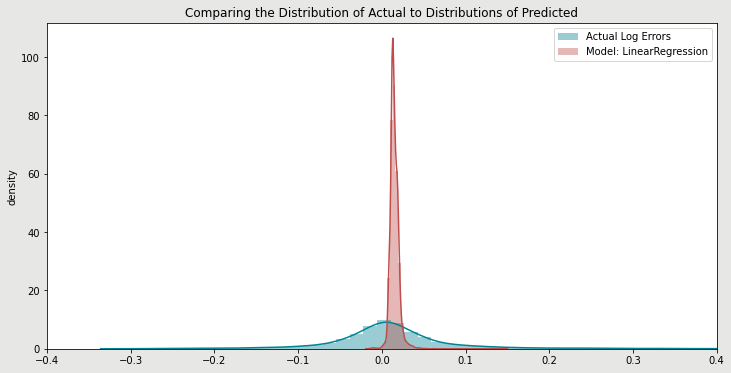

In [54]:
f=plt.figure(figsize=(12, 6))
sns.distplot(y_test, bins=50, kde=True, color=puff[0], 
             label="Actual Log Errors")
sns.distplot(model.predict(X_test_final), bins=50, kde=True,
             color=lucario[1], label="Model: LinearRegression")
f.set_facecolor(lucario[3])
plt.xlim(-.4,.4)
plt.ylabel("density")
plt.xlabel("")
plt.title("Comparing the Distribution of Actual to Distributions of Predicted")
plt.legend()
plt.show()

## Recommendations

Searching for predicatable patterns in Zestimate errors would reveal potential improvements to the model. This analysis shows the the model is already outstanding. There is no juice left to squeeze using the available data. Predictions will never be perfect. A certain level of unknowable, systemic error will always exist in price predictions because buyers are not perfectly rational. It's HIGHLY unlikely that the existing features can be used to improve predictions and no further effort should be made in this direction.